<a href="https://colab.research.google.com/github/gshreya5/colab/blob/main/EDA_Modelling_on_PowerCo_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EDA and Modelling on PowerCo Data provided by BCG


---

**Context**:

---


Client is a major gas and electricity utility

*  Supplies to corporate, SME and residential
customers

Significant churn problem

*  Driven by power-liberalization of the energy
market in Europe
*  Problem is largest in the SME segment

---

**Client's hypothesis**:

---

*  It is possible to predict customers likely to
churn using a predictive model
*  Hypothesis that churn is driven by customer
price sensitivity

Client wants to try discounting strategy
*  SME division head suggests that offering
customers at high propensity to churn a 20%
discount might be effective

---

**Our Take:**

---
In order to test the hypothesis of whether churn is driven by the customers’ price sensitivity, we
would need to model churn probabilities of customers, and derive the effect of prices on churn
rates. We would need the following data to be able to build the models.
Data needed:
1. Customer data - which should include characteristics of each client, for example,
industry, historical electricity consumption, date joined as customer etc.
2. Churn data - which should indicate if customer has churned
3. Historical price data – which should indicate the prices the client charges to each
customer for both electricity and gas at granular time intervals
Once we have the data, the work plan would be:
1. We would need to define what price sensitivity is and calculate it
2. We would need to engineer features based on the data that we obtain, and build a
binary classification model (e.g. Logistic Regression, Random Forest, Gradient Boosted
Machines to name a few),
3. The best model would be picked based on the tradeoff between the complexity, the
explainability, and the accuracy of the models.
4. We would subsequently dive deeper into why and how price changes impact churn.
5. Last but not least, the model would allow us to size the business impact of the client’s
proposed discounting strategy. 

# Load Libraries

In [276]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
sns.set(color_codes=True)

# Load Dataset

In [4]:
client = pd.read_csv('https://cdn.theforage.com/vinternships/companyassets/SKZxezskWgmFjRvj9/BqF6gmrmLunCkdqKM/1639044685365/client_data.csv')
price = pd.read_csv('https://cdn.theforage.com/vinternships/companyassets/SKZxezskWgmFjRvj9/BqF6gmrmLunCkdqKM/1639044717433/price_data.csv')

# EDA

Let's explore the 2 datasets that we have: client and price

In [32]:
client.head(2)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,t,0.0,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,f,0.0,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0


In [12]:
price.head(2)

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0


In [34]:
client.shape, price.shape

((14606, 26), (193002, 8))

In [33]:
client.id.unique().shape, price.id.unique().shape

((14606,), (16096,))

In [41]:
client.isnull().sum().sum(), price.isnull().sum().sum()

(0, 0)

Let's explore column names and data types and understand if they need to be transformed, how to engineer new features 

In [51]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 26 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [48]:
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


Will need to change to datetime format

Let's check **stats**:

In [58]:
price.describe()

,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
std,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221


In [61]:
client.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,churn
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136,0.097152
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743,0.296175
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000,0.000000
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000,0.000000
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500,0.000000
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000,1.000000


Client data looks skewed

# Clean up data

change column type to datetime


In [5]:
price['price_date'] = pd.to_datetime(price['price_date'])

In [6]:
client['date_activ'] = pd.to_datetime(client['date_activ'])
client['date_end'] = pd.to_datetime(client['date_end'])
client['date_modif_prod'] = pd.to_datetime(client['date_modif_prod'])
client['date_renewal'] = pd.to_datetime(client['date_renewal'])

In [7]:
price.price_date.min(),price.price_date.max()

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-01 00:00:00'))

price has data for year 2015

# Visualization

**CHURN**

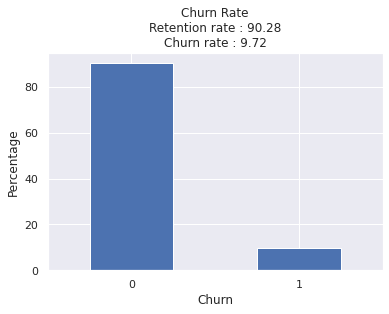

In [55]:
churn_df = (client[['id','churn']].churn.value_counts(normalize=True) * 100)
title = f'Churn Rate\nRetention rate : {round(churn_df[0],2)}\nChurn rate : {round(churn_df[1],2)}'
churn_df.plot(kind='bar',rot=0, title=title,
              xlabel='Churn', ylabel='Percentage');

About 10% customers have churned

**Sales Channel**

In [138]:
channel_sales_df = client[['id','churn','channel_sales']].groupby(['channel_sales','churn']).count().unstack(level=1).fillna(0)
channel_sales_df.columns = [0,1]
channel_sales_df[0] = channel_sales_df[0]/(channel_sales_df[0]+channel_sales_df[1]) *100
channel_sales_df[1] = 100 - channel_sales_df[0]
channel_sales_df.sort_values(by=1, ascending=False,inplace=True)
channel_sales_df


,0,1
channel_sales,,
foosdfpfkusacimwkcsosbicdxkicaua,87.859046,12.140954
usilxuppasemubllopkaafesmlibmsdf,89.963636,10.036364
ewpakwlliwisiwduibdlfmalxowmwpci,91.601344,8.398656
MISSING,92.402685,7.597315
lmkebamcaaclubfxadlmueccxoimlema,94.411286,5.588714
epumfxlbckeskwekxbiuasklxalciiuu,100.000000,0.000000
fixdbufsefwooaasfcxdxadsiekoceaa,100.000000,0.000000
sddiedcslfslkckwlfkdpoeeailfpeds,100.000000,0.000000


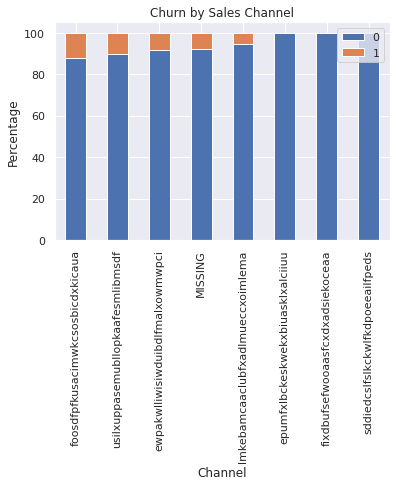

In [139]:
channel_sales_df.plot(kind='bar',stacked=True, rot=90, 
                      title='Churn by Sales Channel', xlabel='Channel', ylabel='Percentage');

Churn rate is over 5% for sales channel

Missing has churn rate of 7.6%

**Consumption**

<Axes: xlabel='imp_cons', ylabel='Density'>

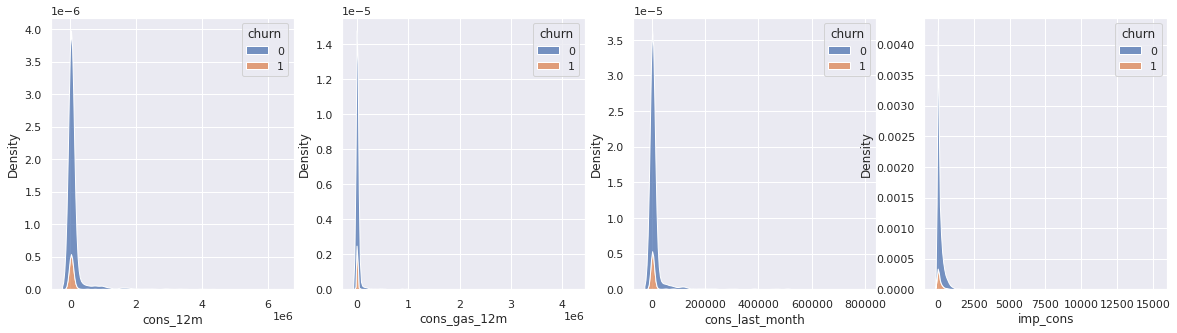

In [191]:
consumption = ['cons_12m', 'cons_gas_12m', 'cons_last_month','imp_cons']
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.kdeplot(data = client, x= consumption[0], hue= 'churn', multiple="stack",ax=axes[0])
sns.kdeplot(data = client, x= consumption[1], hue= 'churn', multiple="stack",ax=axes[1])
sns.kdeplot(data = client, x= consumption[2], hue= 'churn', multiple="stack",ax=axes[2])
sns.kdeplot(data = client, x= consumption[3], hue= 'churn', multiple="stack",ax=axes[3]);

Consumption is highly skewed

Let's check these distribution in detail


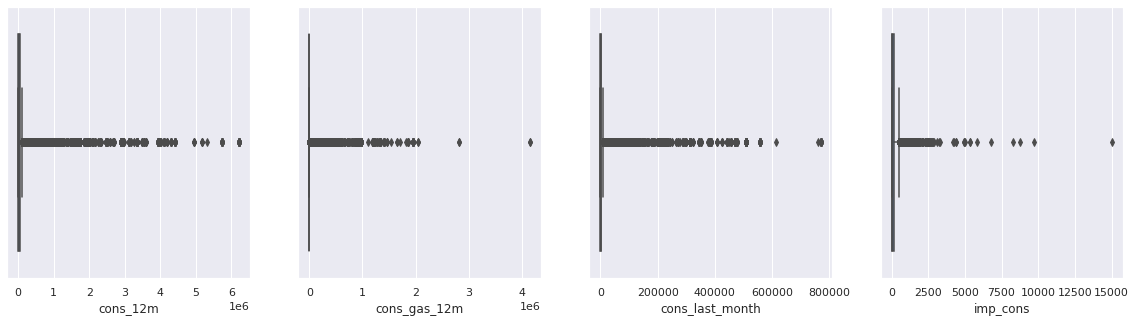

In [198]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
sns.boxplot(data = client, x= consumption[0],ax=axes[0])
sns.boxplot(data = client, x= consumption[1],ax=axes[1])
sns.boxplot(data = client, x= consumption[2],ax=axes[2])
sns.boxplot(data = client, x= consumption[3],ax=axes[3]);

We need to deal with skewness and outliers during feature engineering.


**Contract type**

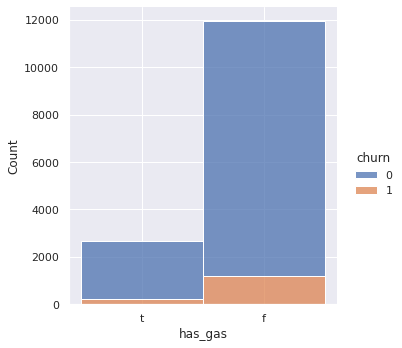

In [216]:
sns.displot(data = client, x= 'has_gas', hue= 'churn', multiple="stack");

**Forecast**

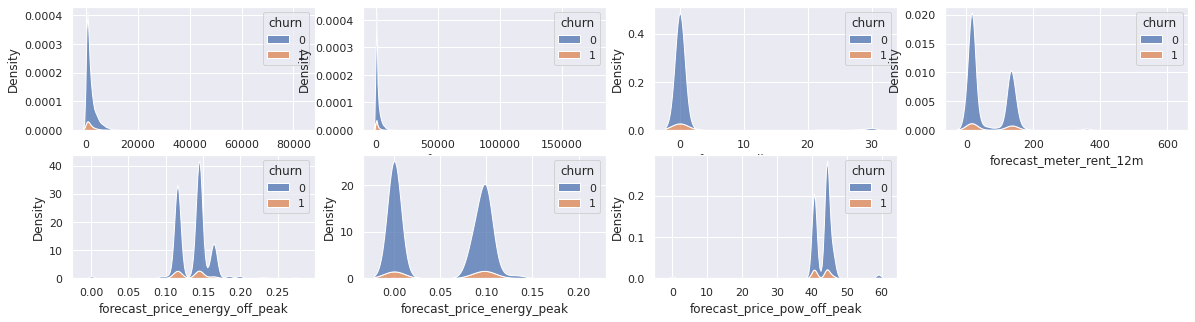

In [214]:
forecast = ["forecast_cons_12m","forecast_cons_year","forecast_discount_energy","forecast_meter_rent_12m",
            'forecast_price_energy_off_peak','forecast_price_energy_peak', 'forecast_price_pow_off_peak']

fig=plt.figure(figsize=(20,5))
columns = 4
rows = 2
for i in range(1, 8):
    fig.add_subplot(rows, columns, i)
    sns.kdeplot(data = client, x= forecast[i-1], hue= 'churn', multiple="stack")
plt.show();



We can see some skewness in data

**Margins**

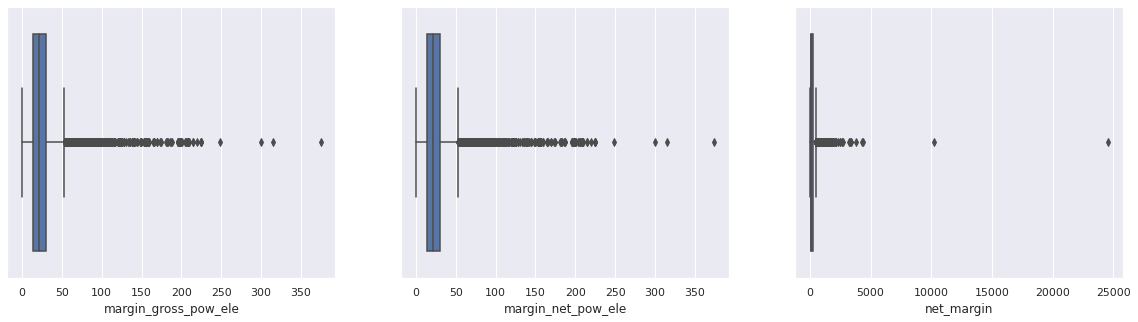

In [218]:
margins= ['margin_gross_pow_ele', 'margin_net_pow_ele','net_margin']
fig=plt.figure(figsize=(20,5))
columns = 3
rows = 1
for i in range(1, 4):
    fig.add_subplot(rows, columns, i)
    sns.boxplot(data = client, x= margins[i-1])
plt.show();

There' some outliers here too

**Subscribed power**

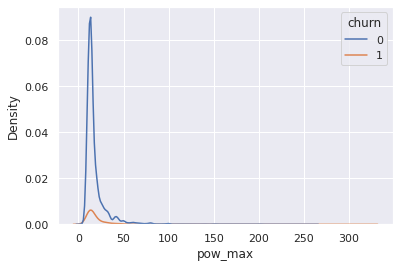

In [222]:
sns.kdeplot(data = client,
            x= 'pow_max',
            hue='churn');

# Calculate price sensitivity

In [228]:
# Create yearly sensitivity features
var_year = price.groupby(['id', 'price_date']).mean().groupby(['id']).var().reset_index()

In [224]:
# Create last 6 months sensitivity features
var_6m = price[price['price_date'] > '2015-06-01'].groupby(['id', 'price_date']).mean().groupby(['id']).var().reset_index()

In [227]:
var_year["var_year_price_off_peak"] = var_year["price_off_peak_var"] + var_year["price_off_peak_fix"]
var_year["var_year_price_peak"] = var_year["price_peak_var"] + var_year["price_peak_fix"]
var_year["var_year_price_mid_peak"] = var_year["price_mid_peak_var"] + var_year["price_mid_peak_fix"]

var_6m["var_year_price_off_peak"] = var_6m["price_off_peak_var"] + var_6m["price_off_peak_fix"]
var_6m["var_year_price_peak"] = var_6m["price_peak_var"] + var_6m["price_peak_fix"]
var_6m["var_year_price_mid_peak"] = var_6m["price_mid_peak_var"] + var_6m["price_mid_peak_fix"]

In [230]:
price_features = pd.merge(var_year, var_6m, on='id')

In [231]:
# Now lets merge in the churn data and see whether price sensitivity has any correlation with churn

price_analysis = pd.merge(price_features, client[['id', 'churn']], on='id')

In [234]:
price_analysis.corr()['churn']


price_off_peak_var_x       0.028646
price_peak_var_x           0.006274
price_mid_peak_var_x       0.010415
price_off_peak_fix_x       0.018930
price_peak_fix_x           0.014674
price_mid_peak_fix_x       0.007956
price_off_peak_var_y       0.019628
price_peak_var_y           0.007991
price_mid_peak_var_y       0.010223
price_off_peak_fix_y       0.011891
price_peak_fix_y           0.013521
price_mid_peak_fix_y       0.005446
var_year_price_off_peak    0.011891
var_year_price_peak        0.013521
var_year_price_mid_peak    0.005446
churn                      1.000000
Name: churn, dtype: float64

correlation between price and churn looks very low.

For price sensivity to be a
major driver for predicting churn, we may need to engineer the features differently

In [235]:
merged_data = pd.merge(client.drop(columns=['churn']), price_analysis,on='id')

It will be helpful if we knew
* Competitor price data - perhaps a client is more likely to churn if a competitor has a good offer
available?
* Average Utilities prices across the country - if PowerCo’s prices are way above or below the country
average, will a client be likely to churn?
* Client feedback - a track record of any complaints, calls or feedback provided by the client to
PowerCo might reveal if a client is likely to churn

# Feature Engineering

## Difference between off-peak prices in December and preceding January


In [237]:
# Group off-peak prices by companies and month
monthly_price_by_id = price.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()
# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()
# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1','price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'),on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] -diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] -diff['price_off_peak_fix']
diff = diff[['id','offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [239]:
df = pd.merge(merged_data, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,price_mid_peak_var_y,price_off_peak_fix_y,price_peak_fix_y,price_mid_peak_fix_y,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


# Average price changes across periods

We can now enhance the feature made by calculating the average price changes
across individual periods, instead of the entire year

In [240]:
# Aggregate average prices per period by company
mean_prices = price.groupby(['id']).agg({
'price_off_peak_var': 'mean',
'price_peak_var': 'mean',
'price_mid_peak_var': 'mean',
'price_off_peak_fix': 'mean',
'price_peak_fix': 'mean',
'price_mid_peak_fix': 'mean'
}).reset_index()

In [243]:
# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var']- mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] -mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] -mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] =mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']


In [244]:
columns = [
'id',
'off_peak_peak_var_mean_diff',
'peak_mid_peak_var_mean_diff',
'off_peak_mid_peak_var_mean_diff',
'off_peak_peak_fix_mean_diff',
'peak_mid_peak_fix_mean_diff',
'off_peak_mid_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_year_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


Instead of looking at differences across an entire year, we have now created
features that look at mean average price differences across different time periods (off_peak, peak,
mid_peak). The dec-jan feature may reveal macro patterns that occur over an entire year, whereas
inter-time-period features may reveal patterns on a micro scale between months.

# Max price changes across periods and months

In [246]:
# Aggregate average prices per period by company
mean_prices_by_month = price.groupby(['id', 'price_date']).agg({
'price_off_peak_var': 'mean',
'price_peak_var': 'mean',
'price_mid_peak_var': 'mean',
'price_off_peak_fix': 'mean',
'price_peak_fix': 'mean',
'price_mid_peak_fix': 'mean'
}).reset_index()

In [247]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] =mean_prices_by_month['price_off_peak_var'] -mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] =mean_prices_by_month['price_peak_var'] -mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] =mean_prices_by_month['price_off_peak_var'] -mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] =mean_prices_by_month['price_off_peak_fix'] -mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] =mean_prices_by_month['price_peak_fix'] -mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] =mean_prices_by_month['price_off_peak_fix'] -mean_prices_by_month['price_mid_peak_fix']


In [248]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
'off_peak_peak_var_mean_diff': 'max',
'peak_mid_peak_var_mean_diff': 'max',
'off_peak_mid_peak_var_mean_diff': 'max',
'off_peak_peak_fix_mean_diff': 'max',
'peak_mid_peak_fix_mean_diff': 'max',
'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
columns={
'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
'off_peak_mid_peak_var_mean_diff':'off_peak_mid_peak_var_max_monthly_diff',
'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
'off_peak_mid_peak_fix_mean_diff':'off_peak_mid_peak_fix_max_monthly_diff'
}
)

In [249]:
columns = [
'id',
'off_peak_peak_var_max_monthly_diff',
'peak_mid_peak_var_max_monthly_diff',
'off_peak_mid_peak_var_max_monthly_diff',
'off_peak_peak_fix_max_monthly_diff',
'peak_mid_peak_fix_max_monthly_diff',
'off_peak_mid_peak_fix_max_monthly_diff'
]

In [250]:
df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


As
a Utilities customer, there is nothing more annoying than sudden price changes between months,
and a large increase in prices within a short time span would be an influencing factor in causing
me to look at other utilities providers for a better deal.


## Tenure

How long a company has been a client of PowerCo.


In [252]:
df['tenure'] = ((df['date_end'] - df['date_activ'])/ np.timedelta64(1, 'Y')).astype(int)

In [253]:
df.groupby(['tenure']).agg({'churn': 'mean'}).sort_values(by='churn',ascending=False)

,churn
tenure,
3,0.143713
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


We can see that companies who have only been a client for 4 or less months are much more likely
to churn compared to companies that have been a client for longer. Interestingly, the difference
between 4 and 5 months is about 4%, which represents a large jump in likelihood for a customer to
churn compared to the other differences between ordered tenure values. Perhaps this reveals that
getting a customer to over 4 months tenure is actually a large milestone with respect to keeping
them as a long term customer.
This is an interesting feature to keep for modelling because clearly how long you’ve been a client,
has a influence on the chance of a client churning.

## Transforming dates into months

* months_activ = Number of months active until reference date (Jan 2016)
* months_to_end = Number of months of the contract left until reference date (Jan 2016)
* months_modif_prod = Number of months since last modification until reference date (Jan
2016)
* months_renewal = Number of months since last renewal until reference date (Jan 2016)


In [255]:
def convert_months(reference_date, df, column):
#Input a column with timedeltas and return months
  time_delta = reference_date - df[column]
  months = (time_delta / np.timedelta64(1, 'M')).astype(int)
  return months


In [257]:
# Create reference date
reference_date = datetime(2016, 1, 1)
# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')


## Transforming Boolean data


In [258]:
df['has_gas'] = df['has_gas'].replace(['t', 'f'], [1, 0])
df.groupby(['has_gas']).agg({'churn': 'mean'})


,churn
has_gas,
0,0.100544
1,0.081856


If a customer also buys gas from PowerCo, it shows that they have multiple products and are a
loyal customer to the brand. Hence, it is no surprise that customers who do not buy gas are almost
2% more likely to churn than customers who also buy gas from PowerCo. Hence, this is a useful
feature.

##  Transforming categorical data

In [259]:
# Transform into categorical type
df['channel_sales'] = df['channel_sales'].astype('category')
# Let's see how many categories are within this column
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6754
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

Since last 3 channels has very few data, we'll drop those

In [260]:
df = pd.get_dummies(df, columns=['channel_sales'], prefix='channel')
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds','channel_epumfxlbckeskwekxbiuasklxalciiuu','channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,3,30,5,2,6,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,7,76,7,76,4,1,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,6,68,3,68,8,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,6,69,2,69,9,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,6,71,2,71,9,1,0,0,0,0


In [261]:
# Transform into categorical type
df['origin_up'] = df['origin_up'].astype('category')
# Let's see how many categories are within this column
df['origin_up'].value_counts()


lxidpiddsbxsbosboudacockeimpuepw    7097
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similar to channel_sales the last 3 categories in the output above show very low frequency, so we
will remove these from the features after creating dummy variables.

In [262]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_MISSING','origin_up_usapbepcfoloekilkwsdiboslwaxobdp','origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,...,71,9,1,0,0,0,0,1,0,0


## Transforming numerical data

We will use the ‘Logarithm’ transformation for the positively skewed features.


Note: We cannot apply log to a value of 0, so we will add a constant of 1 to all the values


In [263]:
skewed = [
'cons_12m',
'cons_gas_12m',
'cons_last_month',
'forecast_cons_12m',
'forecast_cons_year','forecast_discount_energy',
'forecast_meter_rent_12m',
'forecast_price_energy_off_peak',
'forecast_price_energy_peak',
'forecast_price_pow_off_peak'
]
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


We can see that the standard deviation for most of these features is quite high.


In [264]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [265]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,4.223939,0.779244,2.264646,2.962177,1.784610,0.966726,1.517203,0.137283,0.050491,43.130056
std,0.884515,1.717071,1.769305,0.683592,1.584986,5.108289,0.571481,0.024623,0.049037,4.485988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754023,0.000000,0.000000,2.695477,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149727,0.000000,2.899547,3.046836,2.498311,0.000000,1.296555,0.143166,0.084138,44.311378
75%,4.610285,0.000000,3.529430,3.380716,3.242231,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


Now we can see that for the majority of the features, their standard deviation is much lower after
transformation. This is a good thing, it shows that these features are more stable and predictable
now.

Let’s quickly check the distributions of some of these features too

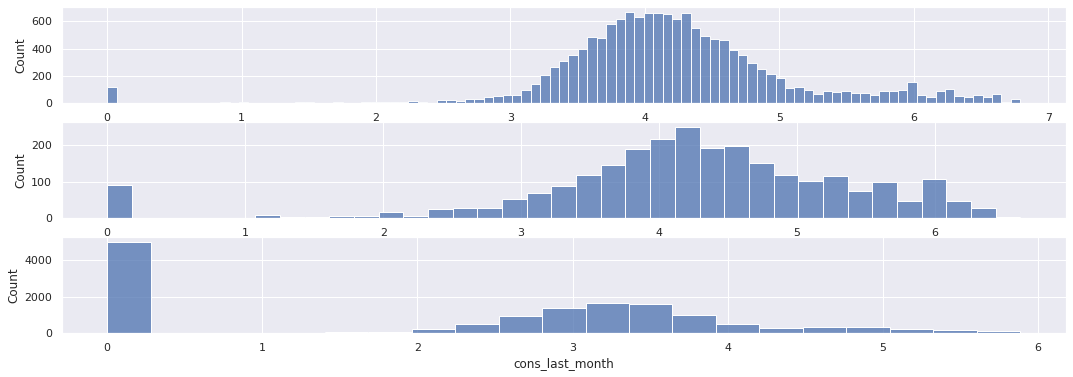

In [270]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 6))
# Plot histograms
sns.histplot((df["cons_12m"].dropna()), ax=axs[0])
sns.histplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.histplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()


## Correlations

In [273]:
correlation = df.corr()

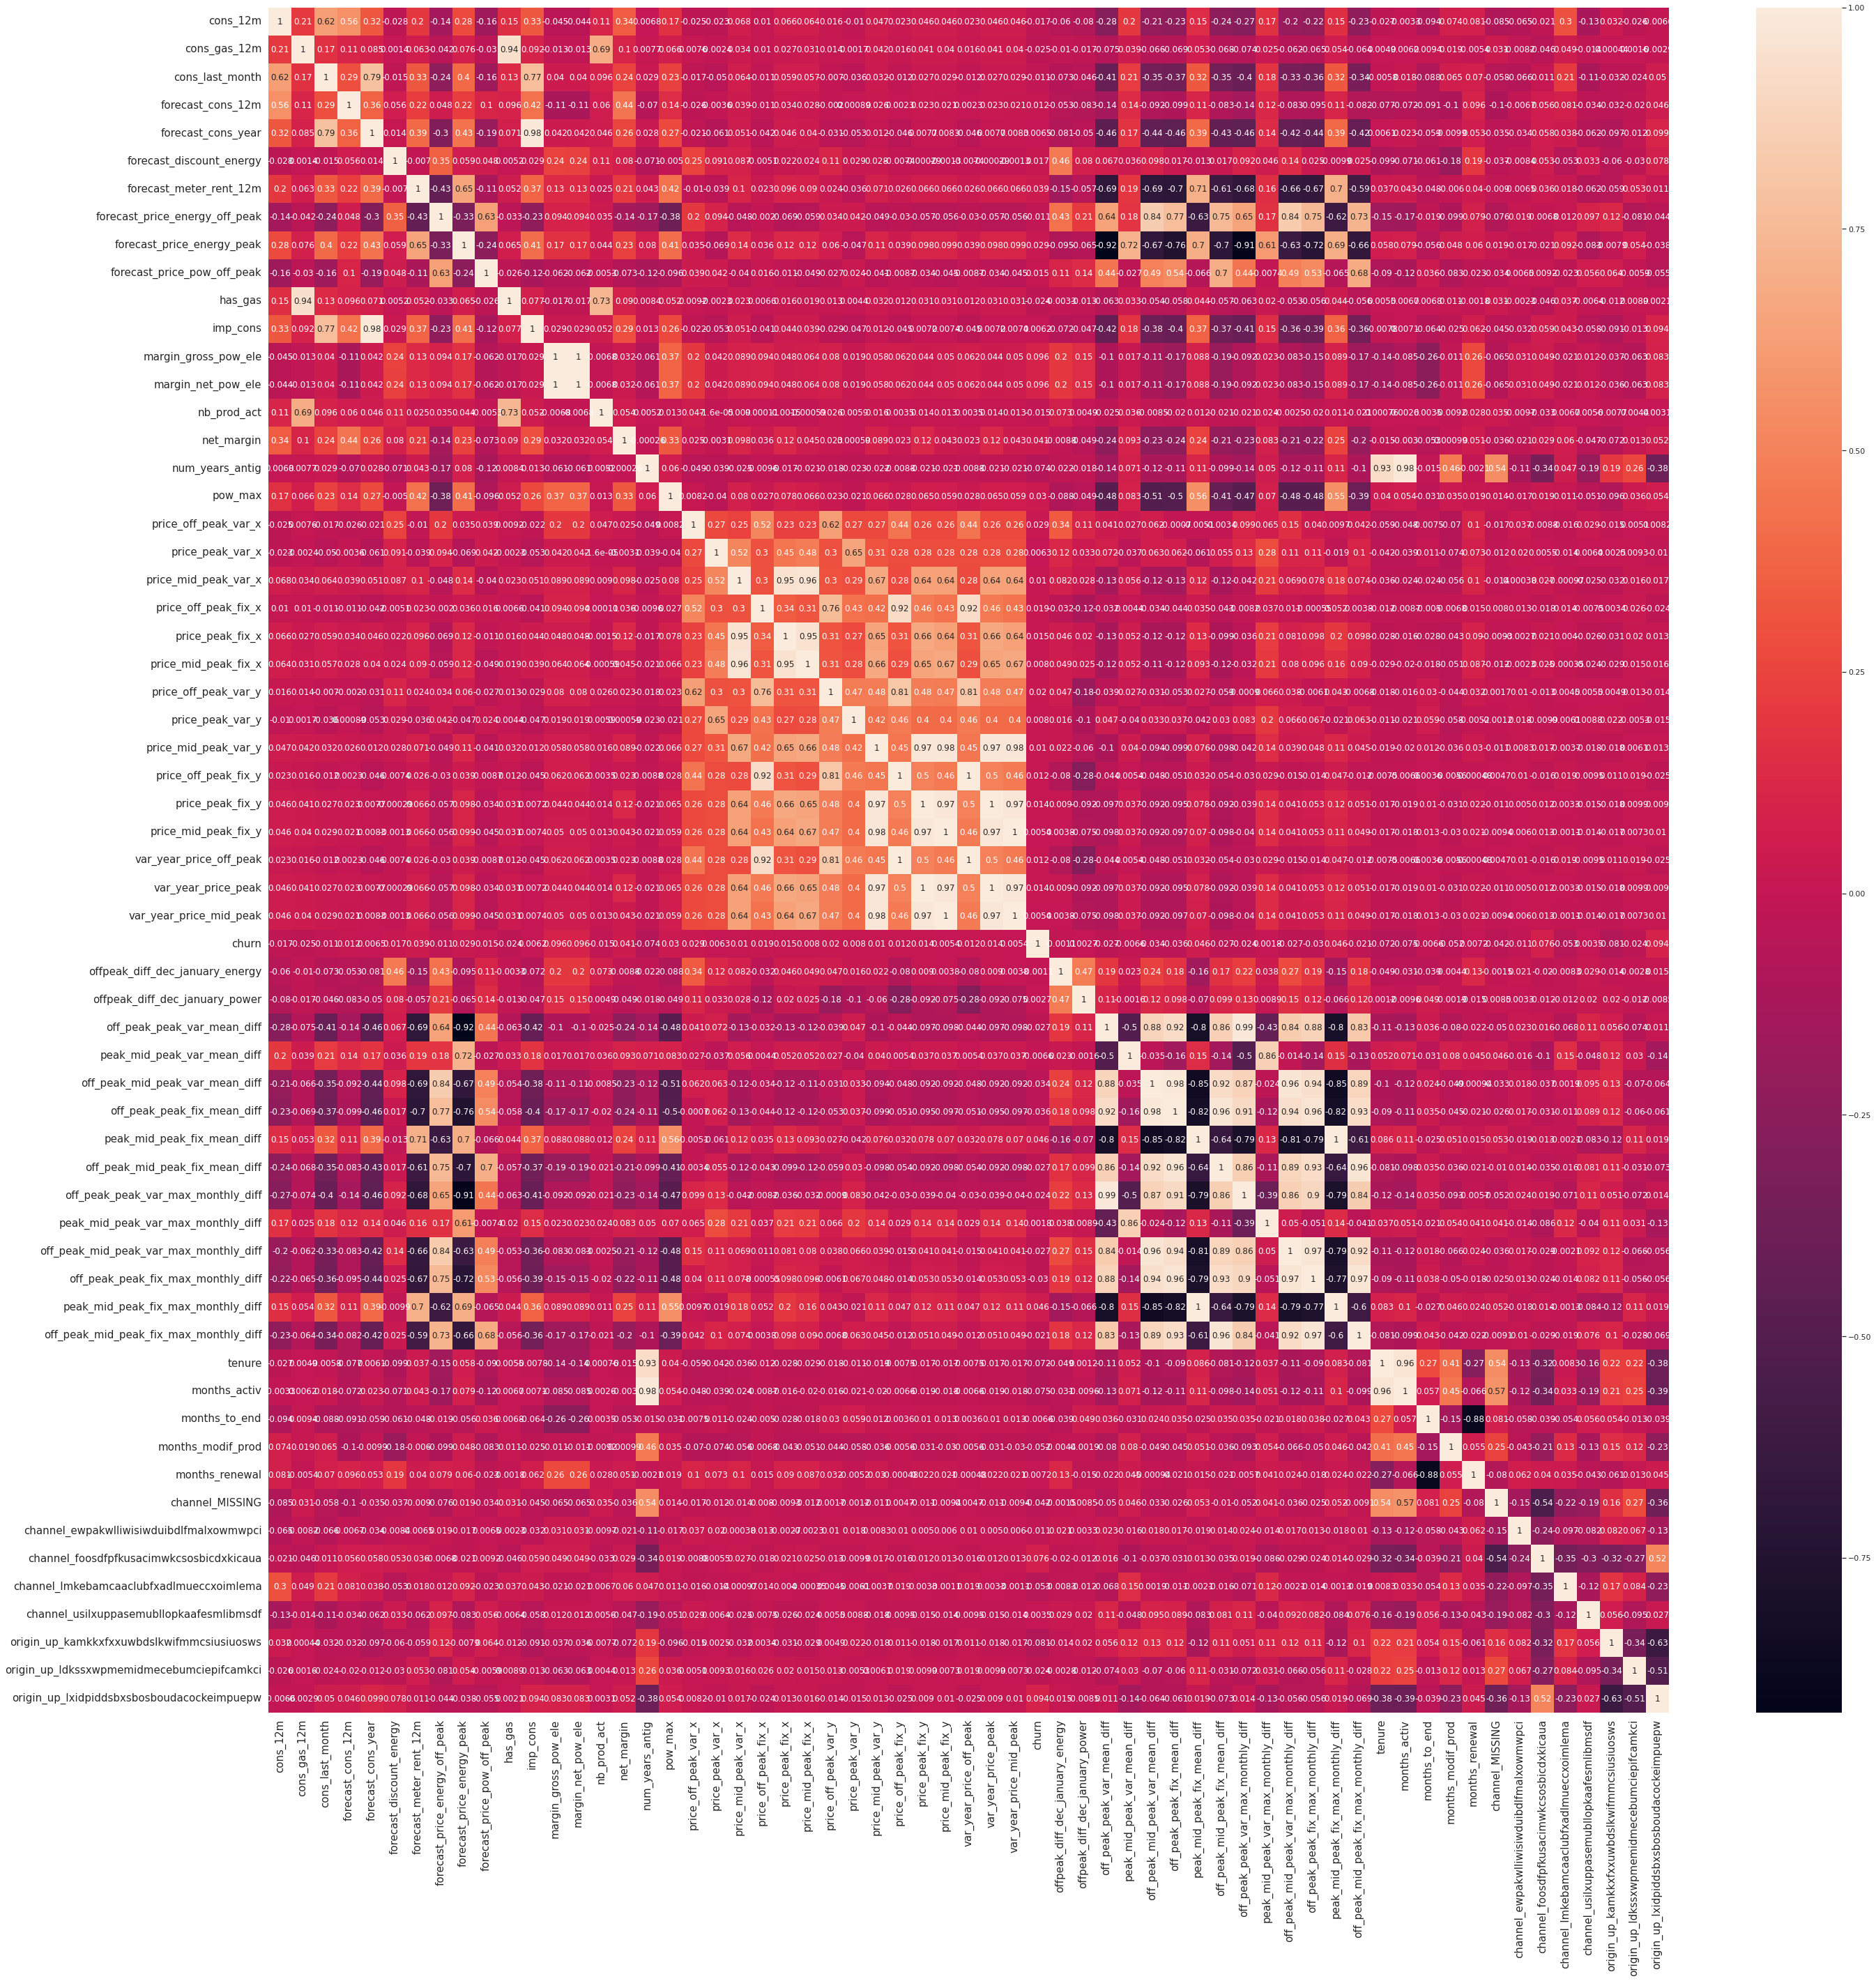

In [274]:
# Plot correlation
plt.figure(figsize=(45, 45))
sns.heatmap(
correlation,
xticklabels=correlation.columns.values,
yticklabels=correlation.columns.values,
annot=True,
annot_kws={'size': 12}
)
# Axis ticks size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

I will remove two variables which exhibit a high correlation with other independent
features.

In [275]:
df = df.drop(columns=['num_years_antig', 'forecast_cons_year','date_activ',
       'date_end', 'date_modif_prod', 'date_renewal'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_discount_energy,...,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.000000,0.0,...,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2009-08-21,2016-08-30,2009-08-21,2015-08-31,2.280920,0.0,...,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,2010-04-16,2016-04-16,2010-04-16,2015-04-17,1.689841,0.0,...,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2010-03-30,2016-03-30,2010-03-30,2015-03-31,2.382089,0.0,...,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2010-01-13,2016-03-07,2010-01-13,2015-03-09,2.650065,0.0,...,71,9,1,0,0,0,0,1,0,0


# Modelling

In [282]:
# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

In [283]:
model = RandomForestClassifier(
n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

## Evaluation

* Accuracy = the ratio of correctly predicted observations to the total observations
* Precision = the ability of the classifier to not label a negative sample as positive
* Recall = the ability of the classifier to find all the positive samples

In [284]:
predictions = model.predict(X_test)
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [285]:
y_test.value_counts()

0    3286
1     366
Name: churn, dtype: int64

In [286]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")
print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 18
False positives: 3
True negatives: 3283
False negatives: 348

Accuracy: 0.9038882803943045
Precision: 0.8571428571428571
Recall: 0.04918032786885246


Within the test set about 10% of the rows are churners (churn = 1).
* Looking at the true negatives, we have 3283 out of 3286. This means that out of all the
negative cases (churn = 0), we predicted 3282 as negative (hence the name True negative).
This is great!
* Looking at the false negatives, this is where we have predicted a client to not churn (churn
= 0) when in fact they did churn (churn = 1). This number is quite high at 348, we want to
get the false negatives to as close to 0 as we can, so this would need to be addressed when
improving the model.
* Looking at false positives, this is where we have predicted a client to churn when they actually
didnt churn. For this value we can see there are 3 cases, which is great!
* With the true positives, we can see that in total we have 366 clients that churned in the test
dataset. However, we are only able to correctly identify 18 of those 366, which is very poor.
* Looking at the accuracy score, this is very misleading! Hence the use of precision and recall
is important. The accuracy score is high, but it does not tell us the whole story.
* Looking at the precision score, this shows us a score of 0.86 which is not bad, but could be
improved.
* However, the recall shows us that the classifier has a very poor ability to identify positive
samples. This would be the main concern for improving this model!


So overall, we’re able to very accurately identify clients that do not churn, but we are not able
to predict cases where clients do churn! What we are seeing is that a high % of clients are being
identified as not churning when they should be identified as churning. This in turn tells me that
the current set of features are not discriminative enough to clearly distinguish between churners
and non-churners.


At this point we should go back to feature engineering to try and create more predictive
features. They may also experiment with optimising the parameters within the model to improve
performance. 

## Feature imp

In [287]:
feature_importances = pd.DataFrame({
'features': X_train.columns,
'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

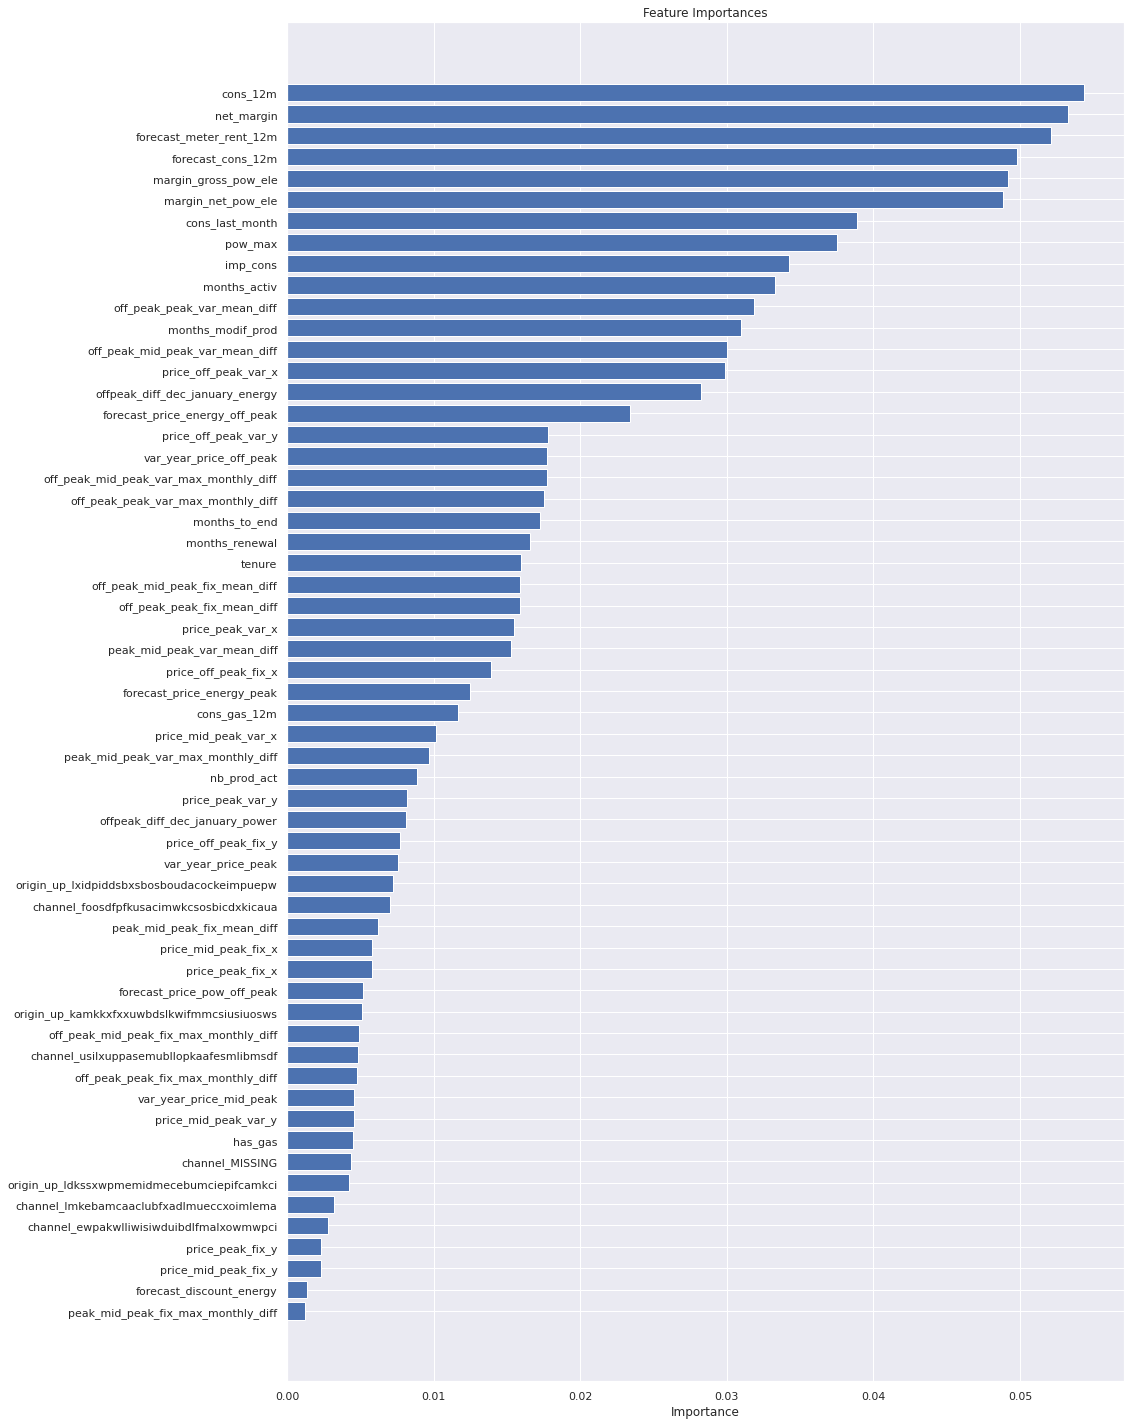

In [289]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'],color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

## Is churn driven by the customers' price sensitivity?

* Our price sensitivity features are scattered around but are not the main driver for a customer
churning

Thus, it is not a main driver rather a weak contributor

* Yearly consumption, forecasted consumption
and net margin are the 3 largest drivers

In [290]:
proba_predictions = model.predict_proba(X_test)
probabilities = proba_predictions[:, 1]


In [291]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [293]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()

## A brief analysis on the discount strategy proposed

The SME division head proposed that we give a 20% discount to high propensity to churn customers.
We can assume to start that everyone who is offered a discount will accept it.


Our task is to calculate the forecast revenue for the set of customers:
1. When no discount is offered
2. And when a discount is offered based on a probability cutoff to decide who should receive the
20% discount

And hence to decide where the cut-off should be set in order to maximise revenue


## Calculate a baseline revenue estimate (no intervention)


Calculate a baseline estimate of the electricity revenue for every customer for the next twelve
months based on the forecast consumption and forecast price and actual churn outcome. Call this
basecase_revenue.

* For customers who end up churning, we should reduce our forecast revenue calculation
by 91.9% to account for the customers churn some time between January 2016 and the
start of March 2016. (Not knowing when they churn, a reasonable assumption for the lost
revenue is the average of 100%, corresponding to churn on 1 January 2016, and 83.9%,
corresponding to churn at the end of February, or 59 days into a 365 day year). Call
this new variable basecase_revenue_after_churn, ie basecase_revenue_after_churn =
basecase_revenue(1 -0.919 churn)


In [294]:
test_df = X_test.copy()

In [295]:
# Electricity revenue for each customer consists of energy consumption (amount* price) and the meter rent
# (the power price may also play a role, but we will ignore it for now since we need to ask the client for more data)
# Note that we need to reverse the log10-transformation from the data cleaning step
test_df['basecase_revenue'] = (np.power(10, test_df['forecast_cons_12m']) + 1)* test_df['forecast_price_energy_off_peak'] +test_df['forecast_meter_rent_12m']
# Taking churn into account
test_df['basecase_revenue_after_churn'] = test_df['basecase_revenue'] * (1 - 0.919 * test_df['churn'])


## Calculate the estimated benefits and costs of intervention


Now, pick a cut-off probability (eg 0.5) so that:
* Customers with a higher churn probability than the cut-off get a discount, and
* Customers below the churn-probability do not get a discount.

From this, calculate the revenue of the intervention scenario assuming: - All customers who
are offered a discount accept it - Customers who do receive a discount are are assumed not to
churn in the next twelve months (ie churn probability = 0), and therefore the retained revenue is
0.8basecase_revenue , being (1-discount_fraction)basecase_revenue - Customers who do not
receive a discount are assumed to churn based on the observed dependent variable (ie, a 1 or 0 for
whether they actually churned or not).

Now, map out the revenue delta as a function of the cut-off probability in a graph. What cut-ofprobability approximately optimises the revenue outcome? Assume for these calculations that the
customer does not consume more or less electricity because the price changes. In practice, we would
expect that if the customer’s cost goes down then their consumption might increase. We will see
two counterbalancing effects at play:

* For true positives we will see revenue retention vs the no-discount scenario
* For false positives we will see reduced revenue from giving them a discount when they wouldn’t
in fact churn.


(False negatives represent an opportunity cost but not an actual cost difference between the two
scenarios.)
The optimal cut-off point will balance the benefits from true positives against the costs of false
positives. Our task is to approximately find the optimal cut-off point. We may need to make
additional assumptions. If we feel the assumptions above aren’t justified and that others are better
then we should modify our assumptions

In [296]:
def get_rev_delta(pred: pd.DataFrame, cutoff: float=0.5, discount: float=0.2)-> float:
  #Get the delta of revenues for offering discount for all customers with predicted churn risk >= cutoff
  pred['discount_revenue'] = pred['basecase_revenue_after_churn']
  # Churn predicted => discount is given => customer stays for full year,independent of whether the prediction
  # (false positive, "free"/unnecessary discount given) or correct
  pred.loc[pred['churn_probability'] >= cutoff, 'discount_revenue'] =pred['basecase_revenue'] * (1 - discount)
  # Save the revenue delta for each customer in a separate column
  pred['revenue_delta'] = pred['discount_revenue'] -pred['basecase_revenue_after_churn']
  return pred['revenue_delta'].sum()

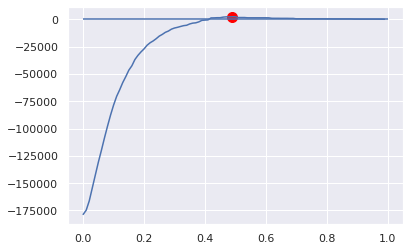

Maximum benefit at cutoff 0.49 with revenue delta of $2,319.50


In [298]:
# Generate a list of possible cutoffs and the corresponding overall revenue deltas
rev_deltas = pd.Series({cutoff: get_rev_delta(test_df, cutoff=cutoff) for cutoff in np.arange(0, 1, 0.01)})
def plot_tradeoff(rev_deltas: pd.Series):
  # Plot the revenue deltas
  rev_deltas.plot()
  # Mark optimal point
  max_pred = rev_deltas.idxmax()
  plt.scatter(max_pred, rev_deltas.loc[max_pred], s=100, c='red')
  # Reference line for break-even
  plt.hlines(0, 0, 1)
  plt.show()
  print(f'Maximum benefit at cutoff {max_pred} with revenue delta of ${rev_deltas.loc[max_pred]:,.2f}')
plot_tradeoff(rev_deltas)


For ref :
https://cdn.theforage.com/vinternships/companyassets/SKZxezskWgmFjRvj9/BqF6gmrmLunCkdqKM/1639046605516/bonus_discount_impact.pdf

Discount strategy of 20% is effective but only if
targeted appropriately 
* Offer discount to only to high-value customers
with high churn probability